In [1]:
# Project - validation data to be given at the end of the course & data not to be shared
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.inspection import DecisionBoundaryDisplay

In [2]:
df_MCF7_unfiltered = pd.read_csv("DropSeq/MCF7_Filtered_Normalised_3000_Data_train.txt", delimiter=' ').T
print("Dataframe dimensions:", np.shape(df_MCF7_unfiltered))
df_MCF7_unfiltered.head()

Dataframe dimensions: (21626, 3000)


,MALAT1,MT-RNR2,NEAT1,H1-5,TFF1,MT-RNR1,H4C3,GDF15,KRT81,MT-CO3,...,MROH1,SKIDA1,MICALL1,RARG,MYO1F,BRWD1-AS2,RPS19BP1,AUNIP,TNK2,SUDS3
AAAAACCTATCG_Normoxia,1,0,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAAACAACCCTA_Normoxia,3,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAAACACTCTCA_Normoxia,3,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAAACCAGGCAC_Normoxia,6,2,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAAACCTAGCTC_Normoxia,4,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [3]:
df_HCC_unfiltered = pd.read_csv("DropSeq/HCC1806_Filtered_Normalised_3000_Data_train.txt", delimiter=' ').T
print("Dataframe dimensions:", np.shape(df_HCC_unfiltered))
df_HCC_unfiltered.head()

Dataframe dimensions: (14682, 3000)


,H1-5,MALAT1,MT-RNR2,ARVCF,BCYRN1,ATXN7L2,IGFBP3,H1-3,CTIF,RNF123,...,BATF3,CDKN3,DLD,PMPCA,ZNF165,SCCPDH,NTAN1,CLIP2,DUSP23,ZNF682
AAAAAACCCGGC_Normoxia,2,3,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
AAAACCGGATGC_Normoxia,2,3,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAAACGAGCTAG_Normoxia,5,2,0,0,1,0,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
AAAACTTCCCCG_Normoxia,1,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAAAGCCTACCC_Normoxia,0,12,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# OUTLIER / NOISE DETECTION FOR DROPSEQ

In what follows we compare the sparsity (proportion of zeros) by row and by column to show that the average sparsity per sample is much higher (by  6%) compared to the sparsity in each gene, thus partially justifying outlier detection and noise detection analysis. (still, since the dataset matrix contains many more rows, samples, than columns, genes, it is expectable that the above holds)

In [4]:
# Filter out samples with more than 90% zeros
sparsity_threshold = 0.9
non_zero_counts = (df_HCC_unfiltered > 0).sum(axis=1)
sample_sparsity = 1 - (non_zero_counts / df_HCC_unfiltered.shape[1])
print(sample_sparsity)
filtered_samples = df_HCC_unfiltered[sample_sparsity <= sparsity_threshold]

# Show how many samples were retained
print("Samples retained:", filtered_samples.shape[0])
print("Samples removed:", df_HCC_unfiltered.shape[0] - filtered_samples.shape[0])

AAAAAACCCGGC_Normoxia    0.979333
AAAACCGGATGC_Normoxia    0.969000
AAAACGAGCTAG_Normoxia    0.983000
AAAACTTCCCCG_Normoxia    0.983000
AAAAGCCTACCC_Normoxia    0.983333
                           ...   
TTTTTACCAATC_Hypoxia     0.985667
TTTTTCCGTGCA_Hypoxia     0.964667
TTTTTGCCTGGG_Hypoxia     0.972333
TTTTTGTAACAG_Hypoxia     0.967667
TTTTTTTGAATC_Hypoxia     0.971333
Length: 14682, dtype: float64
Samples retained: 0
Samples removed: 14682


In [5]:
print(np.mean(sample_sparsity)-np.std(sample_sparsity))

0.9681729688097686


In [6]:
# Filter out samples with more than 90% zeros
sparsity_threshold = 0.90
non_zero_counts = (df_HCC_unfiltered > 0).sum(axis=0)
genes_sparsity = 1 - (non_zero_counts / df_HCC_unfiltered.shape[0])
print(genes_sparsity)
filtered_genes = df_HCC_unfiltered.T[genes_sparsity <= sparsity_threshold]

# Show how many samples were retained
print("Samples retained:", filtered_genes.shape[0])
print("Samples removed:", df_HCC_unfiltered.shape[0] - filtered_genes.shape[0])

H1-5       0.690982
MALAT1     0.384348
MT-RNR2    0.578532
ARVCF      0.998978
BCYRN1     0.531808
             ...   
SCCPDH     0.991759
NTAN1      0.994279
CLIP2      0.997412
DUSP23     0.983313
ZNF682     0.999591
Length: 3000, dtype: float64
Samples retained: 166
Samples removed: 14516


In [7]:
print(np.mean(genes_sparsity)-np.std(genes_sparsity))

0.9046343014825584


## ISO FOREST MCF7

As can be seen below, traditional statistical tests relying on IQR and zscore classify too many points as outliers due to high-dimensionality and sparsity issues. Therefore, we try to implement a more complex model for outlier detection based on random forests, called isolation forest as implemented by scikit-learn.\
This ML algorithm, ISOLATION FOREST, trains is an ensemble of trees for which at each step, a selection of a random feature is performed and then a split value is randomly selected leading to a recusrive partitioning of the feature space, which ends when all samples occupy a different leaf, all leaves are pure. The number of such splits required to arrive (from the first split) to a pure leaf is a measure of normality of the sample and thus used as the model's decision function. This happens because, citing scikit documentation, "Random partitioning produces noticeably shorter paths for anomalies. Hence, when a forest of random trees collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies."

Since the distributions are very much skewed and dataset is very sparse, traditional quartiles and disitribution tests lead to almost all datapoints being considered as outliers 

In what follows, we first apply standrdization to the featured and then apply PCA to the MCF7 (easier) dataset to evalaute how far different data representations can influence the findings of siolation forest. We train the Isolation Forest algorithm using 100 components and visualise the results in 2d.

In [8]:
import umap.umap_ as umap
#data processing
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_MCF7_unfiltered)

# Reduce to 2D with PCA for visualization
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(df_scaled)

#pca for data compression and outlier detection
pca_out = PCA(n_components=2000, random_state=42)
pca_result_out = pca.fit_transform(df_scaled)

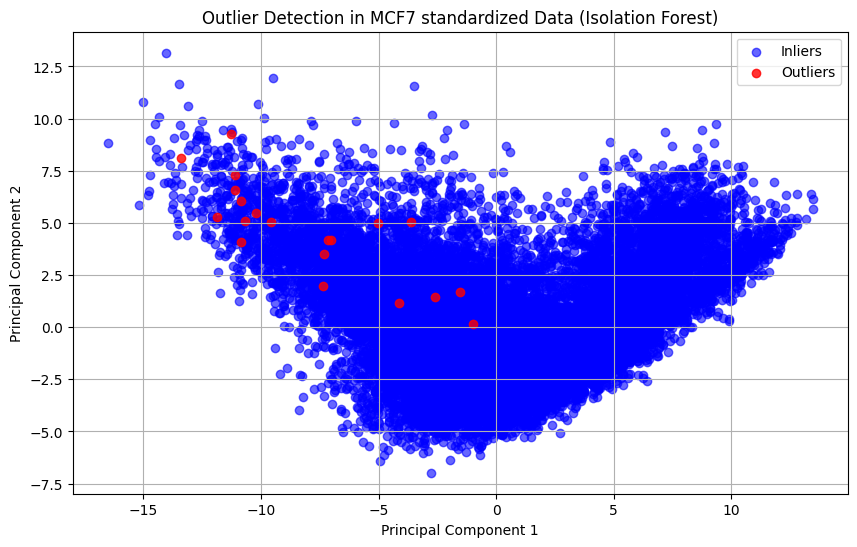

In [9]:
# Apply Isolation Forest to data scaled 
iso_forest = IsolationForest(n_estimators=100, max_features=1, max_samples=100, contamination="auto", n_jobs=10, random_state=4)
outlier_labels_std = iso_forest.fit_predict(df_scaled) #fit the model using only the standardized data

# Add results back to a DataFrame
df_result = pd.DataFrame(df_scaled, columns=df_MCF7_unfiltered.columns)
df_result['outlier'] = outlier_labels_std == -1  # True if outlier
df_result['PC1'] = pca_result[:, 0]
df_result['PC2'] = pca_result[:, 1]

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(df_result.loc[~df_result['outlier'], 'PC1'],
            df_result.loc[~df_result['outlier'], 'PC2'],
            c='blue', label='Inliers', alpha=0.6)
plt.scatter(df_result.loc[df_result['outlier'], 'PC1'],
            df_result.loc[df_result['outlier'], 'PC2'],
            c='red', label='Outliers', alpha=0.8)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Outlier Detection in MCF7 standardized Data (Isolation Forest)')
plt.legend()
plt.grid(True)
plt.show()

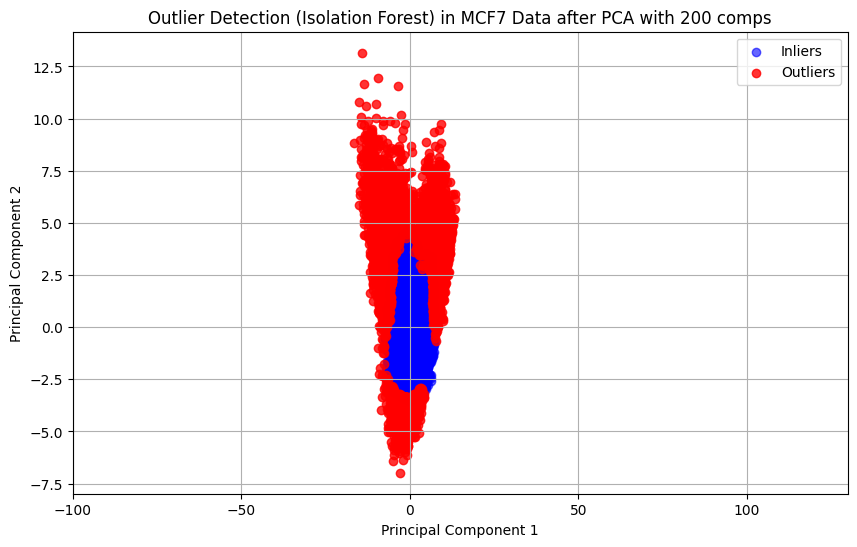

In [10]:
# Apply Isolation Forest to principal components
iso_forest = IsolationForest(n_estimators=100, max_features=1, max_samples=100, contamination="auto", n_jobs=10, random_state=4)
outlier_labels = iso_forest.fit_predict(pca_result_out)

# Add results back to a DataFrame
df_result = pd.DataFrame(df_scaled, columns=df_MCF7_unfiltered.columns)
df_result['outlier'] = outlier_labels == -1  # True if outlier
df_result['PC1'] = pca_result[:, 0]
df_result['PC2'] = pca_result[:, 1]

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(df_result.loc[~df_result['outlier'], 'PC1'],
            df_result.loc[~df_result['outlier'], 'PC2'],
            c='blue', label='Inliers', alpha=0.6)
plt.scatter(df_result.loc[df_result['outlier'], 'PC1'],
            df_result.loc[df_result['outlier'], 'PC2'],
            c='red', label='Outliers', alpha=0.8)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Outlier Detection (Isolation Forest) in MCF7 Data after PCA with 200 comps')
plt.legend()
plt.xlim(-100, 130)
plt.grid(True)
plt.show()

Using the contaimnation = "auto" parameter as is usually done in unsupervised analysis, gives very poor results classifying most of the points as outliers or none of the points probably because of the same sparsity and scaling issues discussed above. Moreover, the results are not consistent since they depend heavily on the data representation as can be seen from teh fact that the dataset after PCA a majority of points considered outliers and before it, instead no point is deemed to be an outlier.Therefore, we suspect method not be highly reliable for our dataset

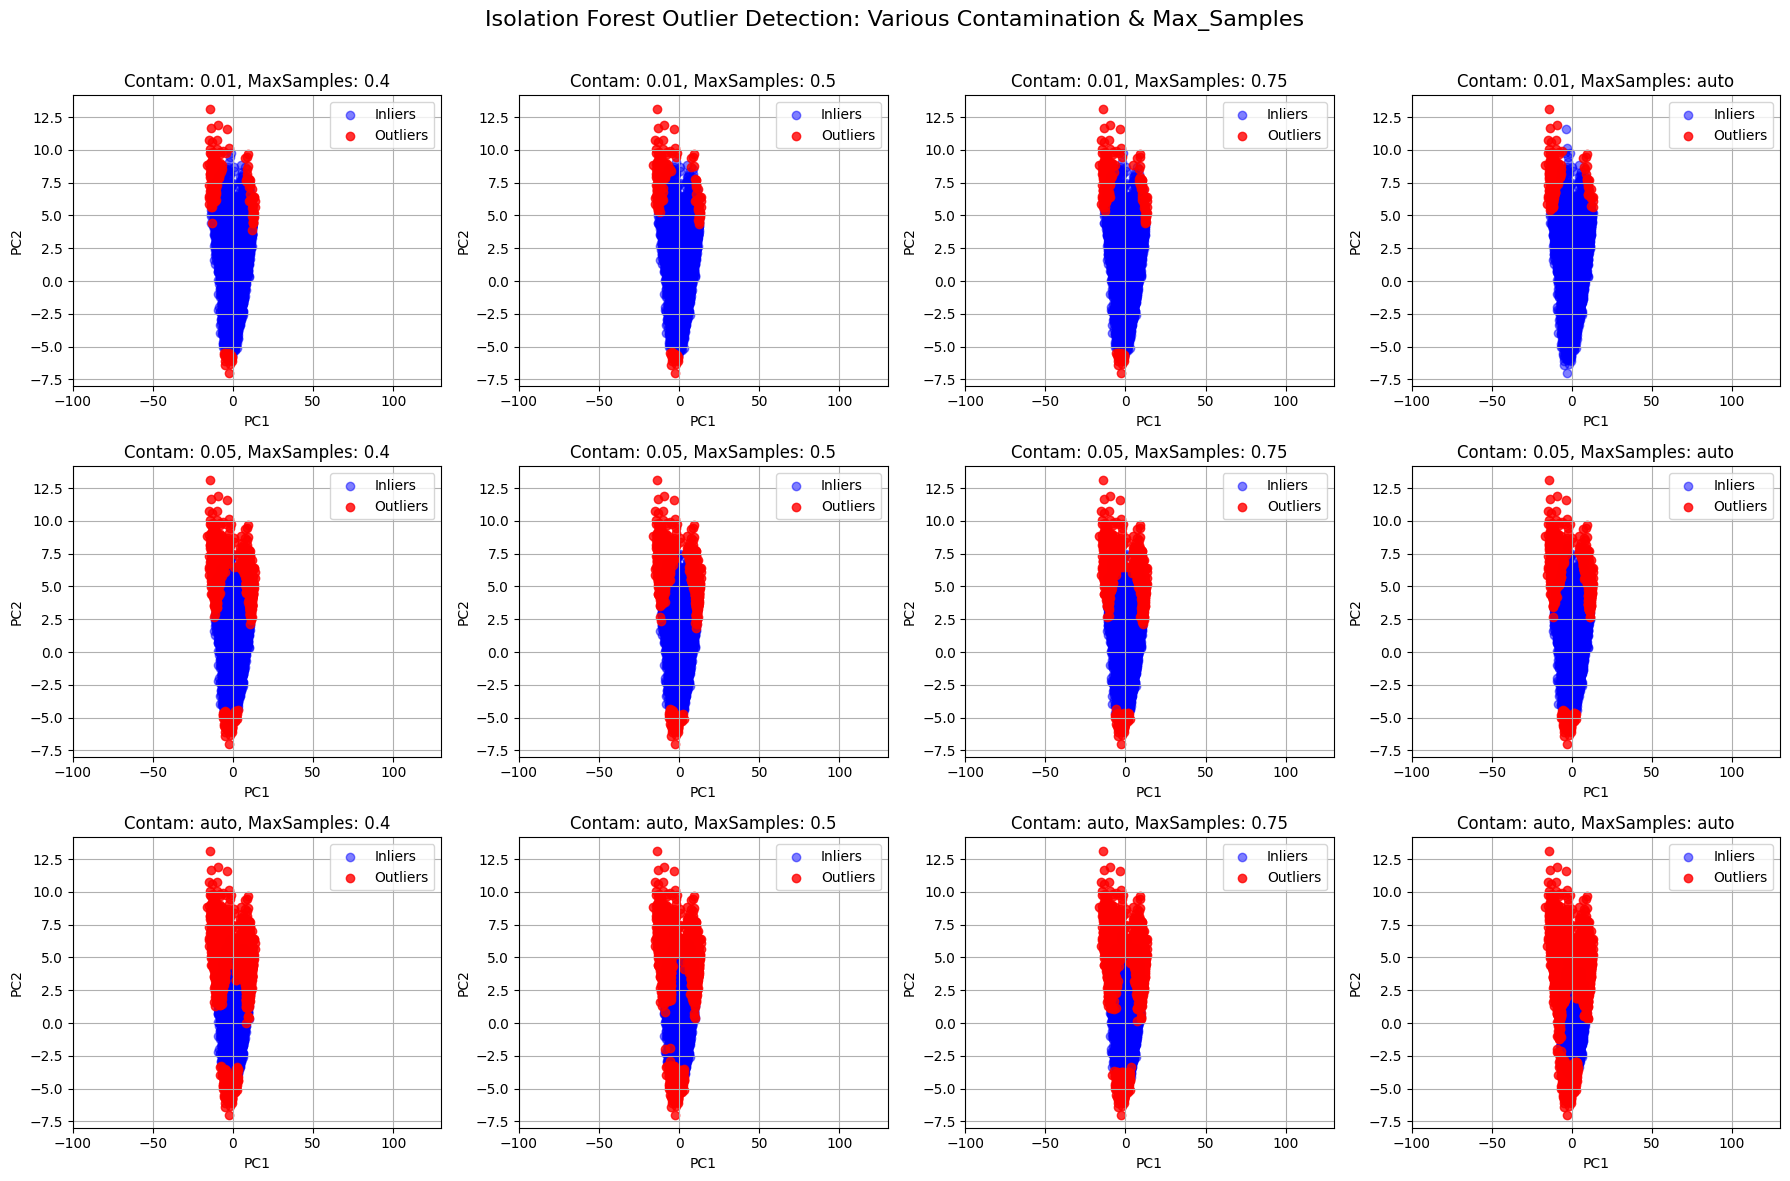

In [11]:
# Parameters to explore
contamination_values = [0.01, 0.05, "auto"] #although the analysis is unsupervised and auto is set explcitly to 0.01,0.05, it is done just to see how the algorithm works and how much
                                            # this affects the outliers predicted. Answer: dependence is too significant and so no really reliable for blind detection 
max_samples_values = [0.4, 0.5, 0.75, 'auto']

# Set up subplot grid
fig, axes = plt.subplots(len(contamination_values), len(max_samples_values), figsize=(18, 12))
fig.suptitle('Isolation Forest Outlier Detection: Various Contamination & Max_Samples', fontsize=16)

for i, contamination in enumerate(contamination_values):
    for j, max_samples in enumerate(max_samples_values):
        # Fit Isolation Forest
        iso_forest = IsolationForest(
            n_estimators=100,
            max_features=1,
            max_samples=max_samples,
            contamination=contamination,
            n_jobs=-1,
            random_state=4
        )
        outlier_labels = iso_forest.fit_predict(pca_result_out)
        outliers = outlier_labels == -1
        
        # Prepare DataFrame for plotting
        df_result = pd.DataFrame({
            'PC1': pca_result[:, 0],
            'PC2': pca_result[:, 1],
            'outlier': outliers
        })
        
        ax = axes[i, j]
        ax.scatter(df_result.loc[~df_result['outlier'], 'PC1'],
                   df_result.loc[~df_result['outlier'], 'PC2'],
                   c='blue', label='Inliers', alpha=0.5)
        ax.scatter(df_result.loc[df_result['outlier'], 'PC1'],
                   df_result.loc[df_result['outlier'], 'PC2'],
                   c='red', label='Outliers', alpha=0.8)
        ax.set_title(f"Contam: {contamination}, MaxSamples: {max_samples}")
        ax.set_xlim(-100, 130)
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        ax.grid(True)

# Only show legend in one plot
for i in range(len(contamination_values)):
    for j in range(len(max_samples_values)):
        axes[i,j].legend()

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

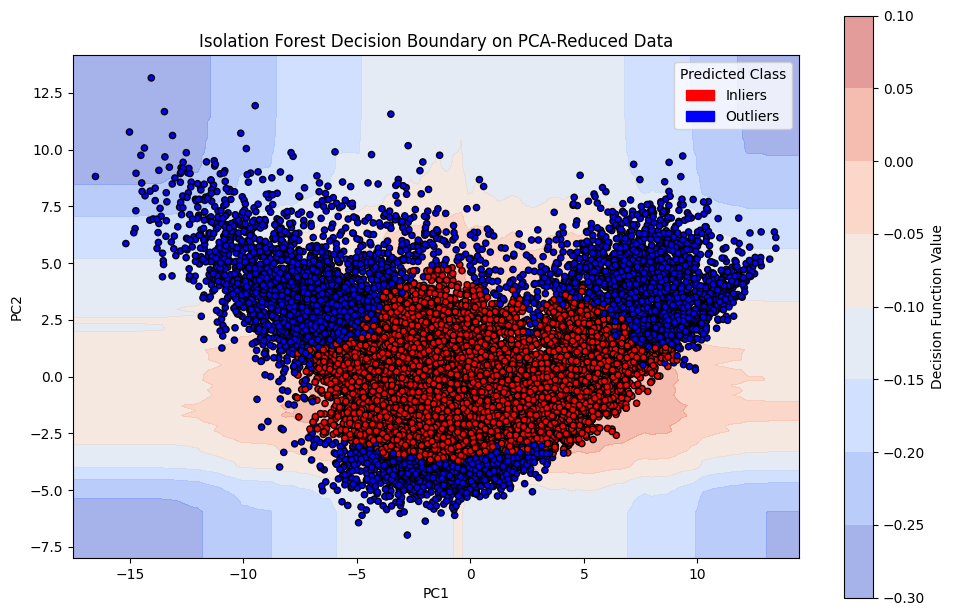

In [12]:
#we try plotting the deciision function for isolation forest to gain more intel on the model's behaviour
clf = IsolationForest(max_samples="auto", contamination="auto", n_estimators=100, max_features=1, random_state=4) 
clf.fit(pca_result_out)
y_M = clf.predict(pca_result_out)

fig, ax = plt.subplots(figsize=(10,10)) 

disp = DecisionBoundaryDisplay.from_estimator(
    clf,
    pca_result_out,
    response_method="decision_function",
    alpha=0.5,
    cmap=plt.cm.coolwarm,
    ax =ax
)
colors = np.where(y_M == -1, "blue", "red")
scatter = disp.ax_.scatter(pca_result[:, 0], pca_result[:, 1], c=colors, s=20, edgecolor="k")

# Plot formatting
# Title and labels
ax.set_title("Isolation Forest Decision Boundary on PCA-Reduced Data")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_aspect('equal')

# Create legend manually
import matplotlib.patches as mpatches
legend_handles = [
    mpatches.Patch(color='red', label='Inliers'),
    mpatches.Patch(color='blue', label='Outliers')
]
ax.legend(handles=legend_handles, title="Predicted Class")

# Add colorbar correctly
cb = plt.colorbar(disp.ax_.collections[0], ax=ax, shrink=0.6)
cb.set_label('Decision Function Value')
plt.tight_layout()
plt.show()

In [13]:
print(f"{sum(y_M==1)} inliers out of {len(y_M)} samples")

15781 inliers out of 21626 samples


In [14]:
y_pred = pd.DataFrame({"labels": y_M})
y_pred.describe()

,labels
count,21626.000000
mean,0.459447
std,0.888226
min,-1.000000
25%,-1.000000
50%,1.000000
75%,1.000000
max,1.000000


In [15]:
# Save to CSV
df_MCF7_filtered = df_MCF7_unfiltered[y_M==1]
df_MCF7_filtered.to_csv('DropSeq/MCF7_train_iso_forest.csv', index=False)

## ISOLATTION Forest HCC1806

The same procedure above is followed to analyse the HCC1806 cell line dataset, yielding almost identical results

In [16]:
import umap.umap_ as umap
#data processing
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_HCC_unfiltered)

# Reduce to 2D with PCA for visualization
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(df_scaled)

#pca for data compression and outlier detection
pca_out = PCA(n_components=2500, random_state=42)
pca_result_out = pca.fit_transform(df_scaled)

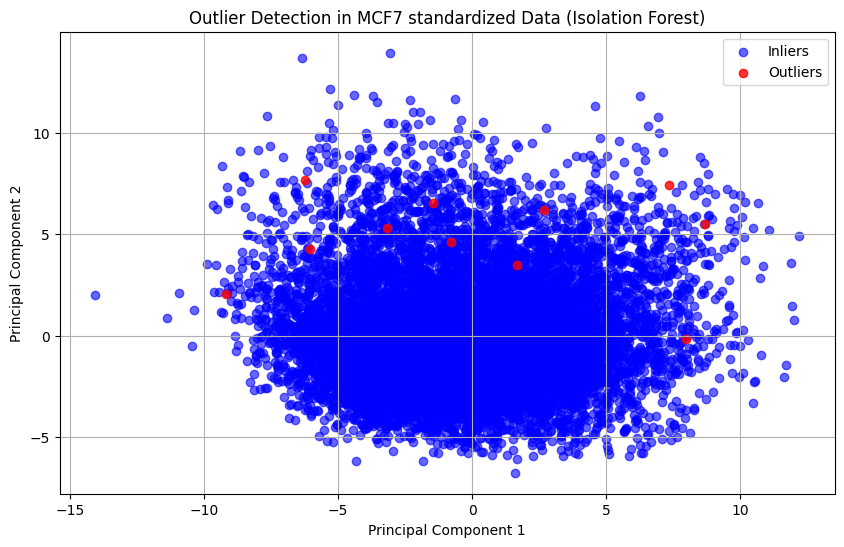

In [17]:
# Apply Isolation Forest to data scaled 
iso_forest = IsolationForest(n_estimators=100, max_features=1, max_samples=100, contamination="auto", n_jobs=10, random_state=4)
outlier_labels_std = iso_forest.fit_predict(df_scaled) #fit the model using only the standardized data

# Add results back to a DataFrame
df_result = pd.DataFrame(df_scaled, columns=df_MCF7_unfiltered.columns)
df_result['outlier'] = outlier_labels_std == -1  # True if outlier
df_result['PC1'] = pca_result[:, 0]
df_result['PC2'] = pca_result[:, 1]

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(df_result.loc[~df_result['outlier'], 'PC1'],
            df_result.loc[~df_result['outlier'], 'PC2'],
            c='blue', label='Inliers', alpha=0.6)
plt.scatter(df_result.loc[df_result['outlier'], 'PC1'],
            df_result.loc[df_result['outlier'], 'PC2'],
            c='red', label='Outliers', alpha=0.8)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Outlier Detection in MCF7 standardized Data (Isolation Forest)')
plt.legend()
plt.grid(True)
plt.show()

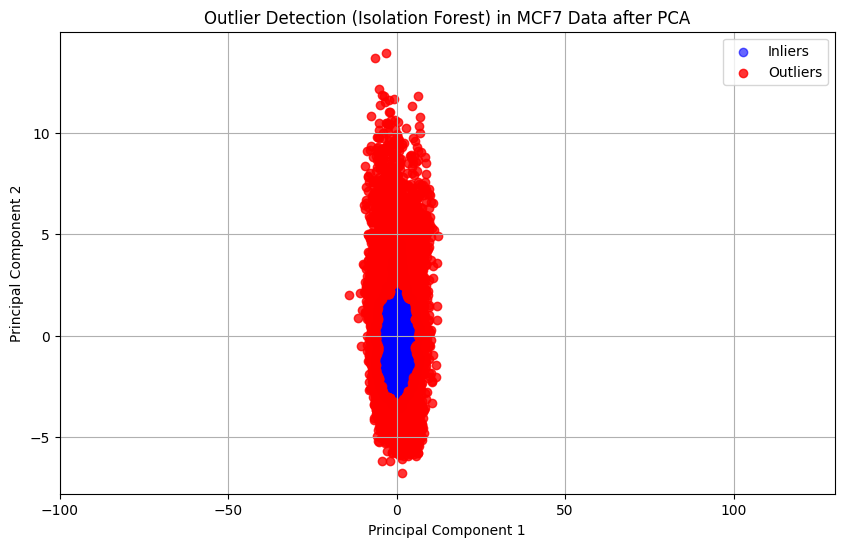

In [18]:
# Apply Isolation Forest to principal components
iso_forest = IsolationForest(n_estimators=100, max_features=1, max_samples=100, contamination="auto", n_jobs=10, random_state=4)
outlier_labels = iso_forest.fit_predict(pca_result_out)

# Add results back to a DataFrame
df_result = pd.DataFrame(df_scaled, columns=df_HCC_unfiltered.columns)
df_result['outlier'] = outlier_labels == -1  # True if outlier
df_result['PC1'] = pca_result[:, 0]
df_result['PC2'] = pca_result[:, 1]

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(df_result.loc[~df_result['outlier'], 'PC1'],
            df_result.loc[~df_result['outlier'], 'PC2'],
            c='blue', label='Inliers', alpha=0.6)
plt.scatter(df_result.loc[df_result['outlier'], 'PC1'],
            df_result.loc[df_result['outlier'], 'PC2'],
            c='red', label='Outliers', alpha=0.8)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Outlier Detection (Isolation Forest) in MCF7 Data after PCA')
plt.legend()
plt.xlim(-100, 130)
plt.grid(True)
plt.show()

Once again, using the contaimnation = "auto" parameter as is usually done in unsupervised analysis, gives very poor results classifying most of the points as outliers or none of the points probably because of the same sparsity and scaling issues discussed above. Moreover, the results are not consistent since they depend heavily on the data representation as can be seen from teh fact that the dataset after PCA a majority of points considered outliers and before it, instead no point is deemed to be an outlier.Therefore, we suspect method not be highly reliable for our dataset

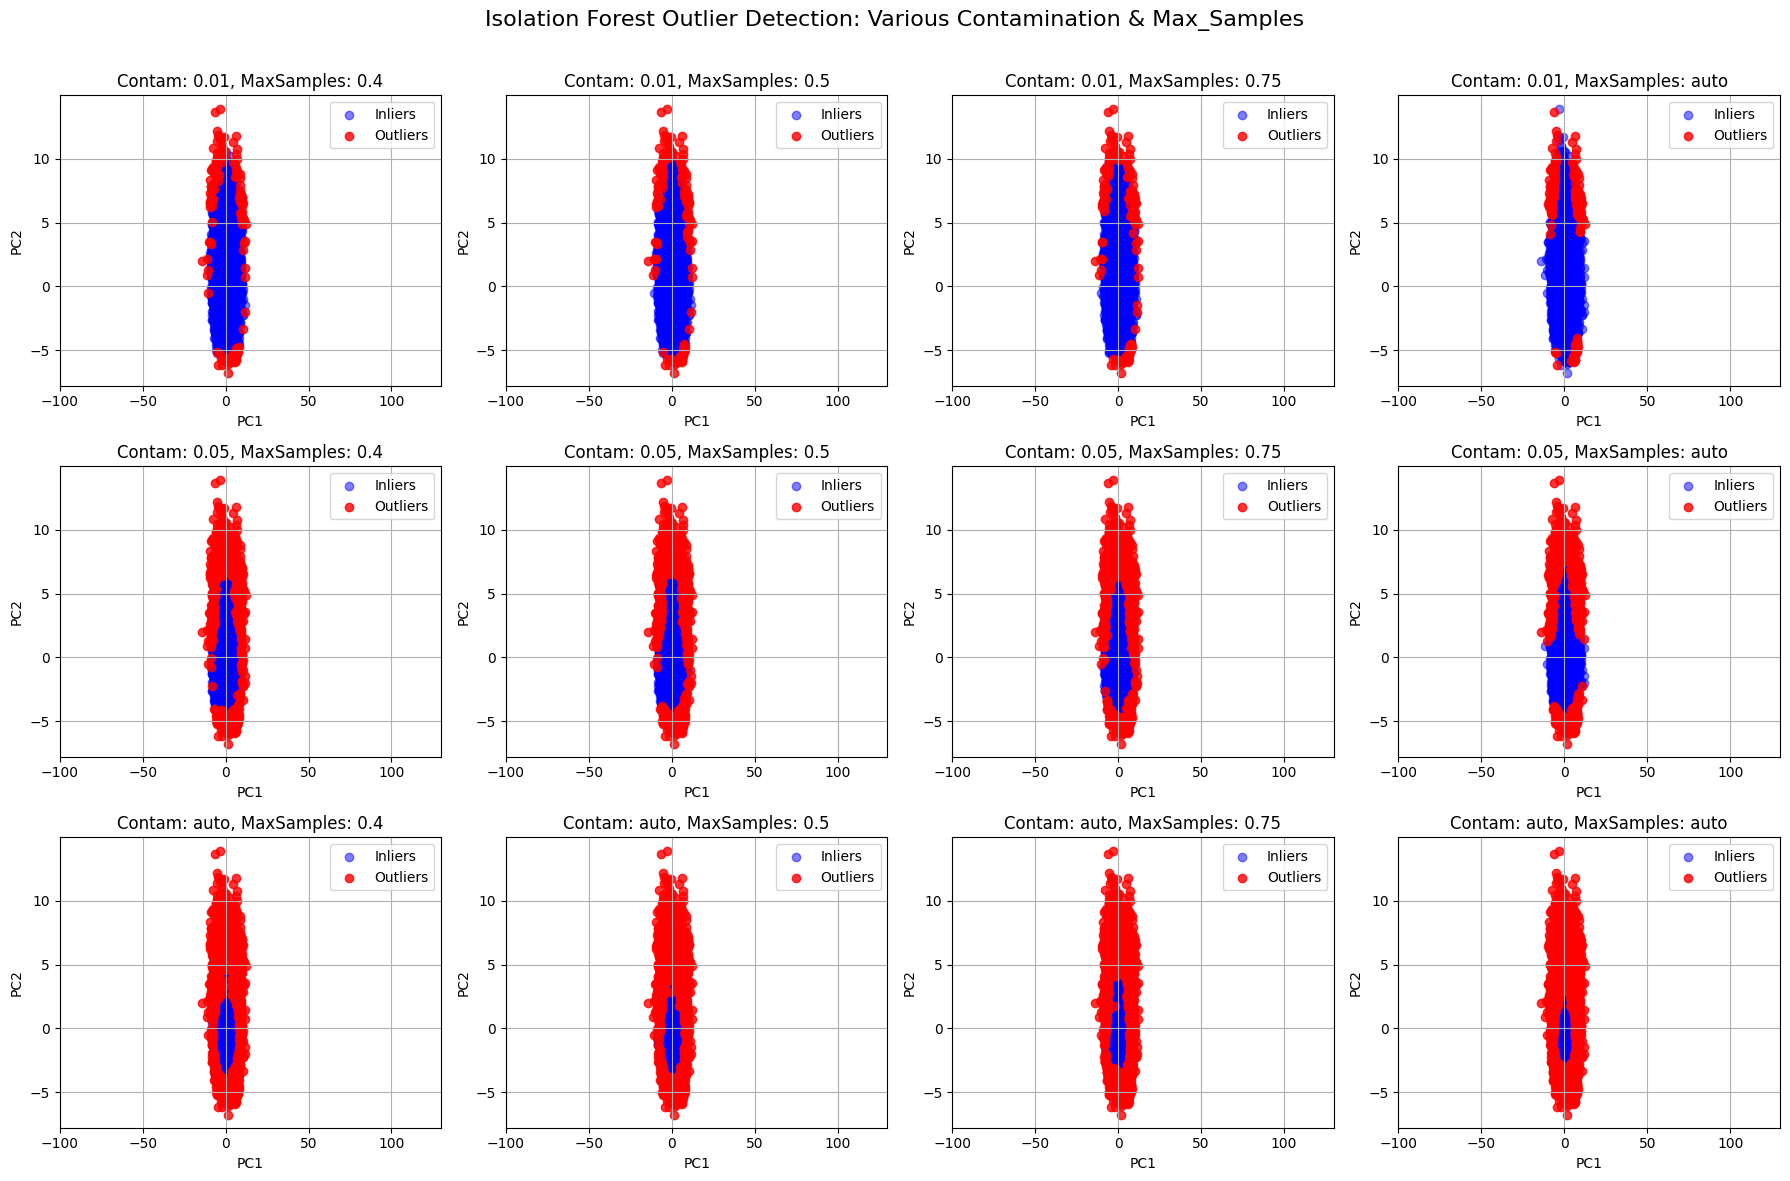

In [19]:
# Parameters to explore
contamination_values = [0.01, 0.05, "auto"] #although the analysis is unsupervised and auto is set explcitly to 0.01,0.05, it is done just to see how the algorithm works and how much
                                            # this affects the outliers predicted. Answer: dependence is too significant and so no really reliable for blind detection 
max_samples_values = [0.4, 0.5, 0.75, 'auto']

# Set up subplot grid
fig, axes = plt.subplots(len(contamination_values), len(max_samples_values), figsize=(18, 12))
fig.suptitle('Isolation Forest Outlier Detection: Various Contamination & Max_Samples', fontsize=16)

for i, contamination in enumerate(contamination_values):
    for j, max_samples in enumerate(max_samples_values):
        # Fit Isolation Forest
        iso_forest = IsolationForest(
            n_estimators=100,
            max_features=1,
            max_samples=max_samples,
            contamination=contamination,
            n_jobs=-1,
            random_state=4
        )
        outlier_labels = iso_forest.fit_predict(pca_result_out)
        outliers = outlier_labels == -1
        
        # Prepare DataFrame for plotting
        df_result = pd.DataFrame({
            'PC1': pca_result[:, 0],
            'PC2': pca_result[:, 1],
            'outlier': outliers
        })
        
        ax = axes[i, j]
        ax.scatter(df_result.loc[~df_result['outlier'], 'PC1'],
                   df_result.loc[~df_result['outlier'], 'PC2'],
                   c='blue', label='Inliers', alpha=0.5)
        ax.scatter(df_result.loc[df_result['outlier'], 'PC1'],
                   df_result.loc[df_result['outlier'], 'PC2'],
                   c='red', label='Outliers', alpha=0.8)
        ax.set_title(f"Contam: {contamination}, MaxSamples: {max_samples}")
        ax.set_xlim(-100, 130)
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        ax.grid(True)

# Only show legend in one plot
for i in range(len(contamination_values)):
    for j in range(len(max_samples_values)):
        axes[i,j].legend()

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

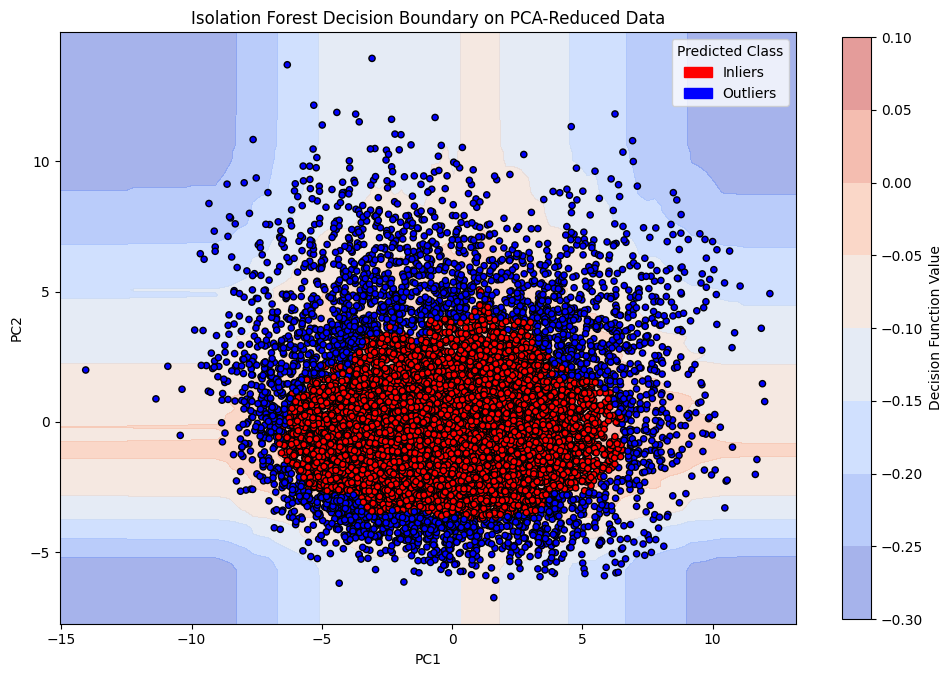

In [ ]:
#we try plotting the deciision function for isolation forest to gain more intel on the model's behaviour
clf = IsolationForest(max_samples="auto", contamination="auto", n_estimators=100, max_features=1, random_state=4) 
clf.fit(pca_result)
y_H = clf.predict(pca_result[:,:2])

fig, ax = plt.subplots(figsize=(10,10)) 

disp = DecisionBoundaryDisplay.from_estimator(
    clf,
    pca_result,
    response_method="decision_function",
    alpha=0.5,
    cmap=plt.cm.coolwarm,
    ax =ax
)
colors = np.where(y_H == -1, "blue", "red")
scatter = disp.ax_.scatter(pca_result[:, 0], pca_result[:, 1], c=colors, s=20, edgecolor="k")

# Plot formatting
# Title and labels
ax.set_title("Isolation Forest Decision Boundary on PCA-Reduced Data")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_aspect('equal')

# legend
import matplotlib.patches as mpatches
legend_handles = [
    mpatches.Patch(color='red', label='Inliers'),
    mpatches.Patch(color='blue', label='Outliers')
]
ax.legend(handles=legend_handles, title="Predicted Class")

# Add colorbar
cb = plt.colorbar(disp.ax_.collections[0], ax=ax, shrink=0.6)
cb.set_label('Decision Function Value')
plt.tight_layout()
plt.show()

In [21]:
print(f"{sum(y_H==1)} inliers out of {len(y_H)} samples")

11400 inliers out of 14682 samples


In [22]:
# Save to CSV
y_pred = pd.DataFrame({"labels": y_H})
y_pred.describe()

df_HCC_filtered = df_HCC_unfiltered[y_H==1]
df_HCC_filtered.to_csv('DropSeq/HCC_train_iso_forest.csv', index=True)

## DISTRIBUTION OF CLASSES OF FOUND INLIER AND OUTLIER CLASSES

In [23]:
#we extract the labels to analyse better the distrbution of classes within the inlier and outliers classes indetified by ISOLATION FOREST
sample_names = df_HCC_unfiltered.T.columns
conditions = []
for name in sample_names:
    if "Norm" in name:
        conditions.append("Norm")
    elif "Hypo" in name:
        conditions.append("Hypo")
    else:
        conditions.append("Unknown")

condition_labels_HCC = np.array([0 if c == "Norm" else 1 if c == "Hypo" else 2 for c in conditions])

sample_names = df_MCF7_unfiltered.T.columns
conditions = []
for name in sample_names:
    if "Norm" in name:
        conditions.append("Norm")
    elif "Hypo" in name:
        conditions.append("Hypo")
    else:
        conditions.append("Unknown")

condition_labels_MCF7 = np.array([0 if c == "Norm" else 1 if c == "Hypo" else 2 for c in conditions])

In [24]:
print(f'Hypoxia samples in full MCF7 dataset: {sum(condition_labels_MCF7)} - {sum(condition_labels_MCF7)/len(condition_labels_MCF7)}', 
f'and Normoxia samples in full MCF7 dataset: {sum(1-condition_labels_MCF7)} - {sum(1-condition_labels_MCF7)/len(condition_labels_MCF7)}')

Hypoxia samples in full MCF7 dataset: 8921 - 0.4125127161749746 and Normoxia samples in full MCF7 dataset: 12705 - 0.5874872838250255


In [25]:
print(f'Hypoxia samples in filtered MCF7 dataset (only with inliers): {sum(condition_labels_MCF7[y_M==1])} - {sum(condition_labels_MCF7[y_M==1])/len(condition_labels_MCF7[y_M==1])}', 
f'and Normoxia samples in filtered MCF7 dataset: {sum(1-condition_labels_MCF7[y_M==1])} - {sum(1-condition_labels_MCF7[y_M==1])/len(condition_labels_MCF7[y_M==1])}')

Hypoxia samples in filtered MCF7 dataset (only with inliers): 6071 - 0.3847031240098853 and Normoxia samples in filtered MCF7 dataset: 9710 - 0.6152968759901147


In [26]:
print(f'Hypoxia samples identified as outliers in MCF7 dataset: {sum(condition_labels_MCF7[y_M==-1])} - {sum(condition_labels_MCF7[y_M==-1])/len(condition_labels_MCF7[y_M==-1])}', 
f'and Normoxia samples identified as outliers in MCF7 dataset: {sum(1-condition_labels_MCF7[y_M==-1])} - {sum(1-condition_labels_MCF7[y_M==-1])/len(condition_labels_MCF7[y_M==-1])}')

Hypoxia samples identified as outliers in MCF7 dataset: 2850 - 0.4875962360992301 and Normoxia samples identified as outliers in MCF7 dataset: 2995 - 0.5124037639007699


In [27]:
print(f'Hypoxia samples in full HCC1806 dataset: {sum(condition_labels_HCC)} - {sum(condition_labels_HCC)/len(condition_labels_HCC)}', 
f'and Normoxia samples in full HCC1806 dataset: {sum(1-condition_labels_HCC)} - {sum(1-condition_labels_HCC)/len(condition_labels_HCC)}')

Hypoxia samples in full HCC1806 dataset: 8899 - 0.6061163329246697 and Normoxia samples in full HCC1806 dataset: 5783 - 0.39388366707533035


In [28]:
print(f'Hypoxia samples in filtered HCC1806 dataset (only with inliers): {sum(condition_labels_HCC[y_H==1])} - {sum(condition_labels_HCC[y_H==1])/len(condition_labels_HCC[y_H==1])}', 
f'and Normoxia samples in filtered HCC1806 dataset: {sum(1-condition_labels_HCC[y_H==1])} - {sum(1-condition_labels_HCC[y_H==1])/len(condition_labels_HCC[y_H==1])}')

Hypoxia samples in filtered HCC1806 dataset (only with inliers): 7019 - 0.6157017543859649 and Normoxia samples in filtered HCC1806 dataset: 4381 - 0.3842982456140351


In [30]:
print(f'Hypoxia samples identified as outliers in HCC1806 dataset: {sum(condition_labels_HCC[y_H==-1])} - {sum(condition_labels_HCC[y_H==-1])/len(condition_labels_HCC[y_H==-1])}', 
f'and Normoxia samples identified as outliers in HCC1806 dataset: {sum(1-condition_labels_HCC[y_H==-1])} - {sum(1-condition_labels_HCC[y_H==-1])/len(condition_labels_HCC[y_H==-1])}')

Hypoxia samples identified as outliers in HCC1806 dataset: 1880 - 0.5728214503351615 and Normoxia samples identified as outliers in HCC1806 dataset: 1402 - 0.42717854966483854


As can be seen from above, the isolation forst doesn't seem to discriminate one of the cell conditions, classifying in a rather balanced way, if a given sample is an outlier, thus preserving the distrbution of classes inherent to the unfiltered full dataset. In this regard, Isolation Forest is successful by not rendering the dataset extremely unbalanced in favour of a class and suggesting that there are outliers/abnormal samples for both classes of observations.

## Final comments on ISOLATION FOREST

As can be seen from above analysis, the results of Isolation Forest appear to be qualitatively/graphically sensible given the plots obtained and provide a good way to detect outliers, when in possession of estimates on the share of outliers in the dataset.
However, the outliers found by the algorithm very much depend on the parmeters used, especially on the contamination parameter, (literally the approximate proportion of outliers) which requires previous knowledge of outlier presence or of anomalies because of some bilogical reason. Since there is no good reason to suppose/assume that any specfic quantity of anomalies were produced in the data, this method does not provide enough evidence for removing or handling differently some datapoints.\
Moreover, Isolation Forest algorithm is also very much dependent upon the data representation since it partitions the feature space. Therefore, if we had applied it to the UMAP or TSNE mebedding, using the same or a similar number of components, we would have gotten completely different results.\
FInally, the method is discarded for future analysis because of the above reasons and the presence of better alternatives

Instead, we will attempt to identify samples corresponding to noise or outliers in the unsupervised analysis file by resorting to more general techniques, namely silhouette score graphs and DBSCAN.

REMARK: the same notebook was run also on the Smartseq dataset, but owing to the small number of samples and their relatively "good" structure (as seen from unsupervised plots) divided in two clusters, most data belonging to one cluster or both was classified as an outlier, which would have reduced dataset size by more than 40%. Thus, in that case, the filtering with isolation forest was completely discarded 

REMARK: since most of ML research is empirically driven, we still attempted to run our supervised learning on the filtered dropseq datasets (only with inliers), but we obtained similar accuracies and performances to the ones on the other datasets. Thus, owing to the danger of removing useful info for classification, we kept all the samples, choosing instead accurately the genes and features of our analysis.